In [87]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, partial_trace
from qiskit.visualization import plot_bloch_multivector, array_to_latex, plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.compiler import transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator

import matplotlib.pyplot as plt
import numpy as np

### (1) $P(\theta) = R_Z(\theta) ?$

$
P(\theta) = \begin{bmatrix}
1 & 0 \\
0 & e^{i\theta}
\end{bmatrix}
$

$
R_Z(\theta) = \begin{bmatrix}
e^{-i\theta/2} & 0 \\
0 & e^{i\theta/2}
\end{bmatrix}
$

$$
e^{i\theta/2}R_Z(\theta)=\begin{bmatrix}
1 & 0 \\
0 & e^{i\theta}
\end{bmatrix}=P(\theta)
$$

Therefore, $P(\theta)=e^{i\theta/2}R_Z(\theta)$.

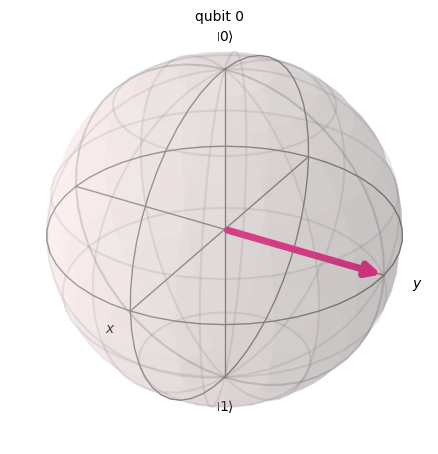

In [2]:
theta = np.pi/2
qc = QuantumCircuit(1)

qc.h(0)
qc.p(theta, 0)

state = Statevector(qc)
plot_bloch_multivector(state)

### (2) Transpile
- [Compiler](https://docs.quantum.ibm.com/api/qiskit/compiler)

In [4]:
qc = QuantumCircuit(3)
qc.h(0)             
qc.p(np.pi / 2, 0) 
qc.cx(0, 1)       
qc.cx(0, 2)  

qc_gate = qc.to_gate()
qc_gate.name = 'qc_original'

In [5]:
qc_transpiled = transpile(qc, basis_gates=["cz", "sx", "rz"], coupling_map=[[0, 1], [1, 2]], optimization_level=3)
qc_transpiled_gate = qc_transpiled.to_gate()
qc_transpiled_gate.name = 'qc_transpiled'

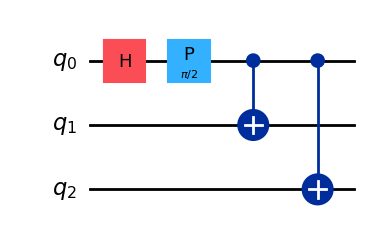

In [6]:
qc.draw("mpl")

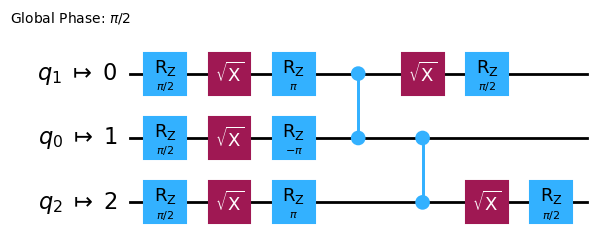

In [7]:
qc_transpiled.draw("mpl")

In [8]:
qc_initial_state = QuantumCircuit(3)
qc_initial_state.h([0,1,2])
qc0_gate = qc_initial_state.to_gate()
qc0_gate.name = 'initial_state'

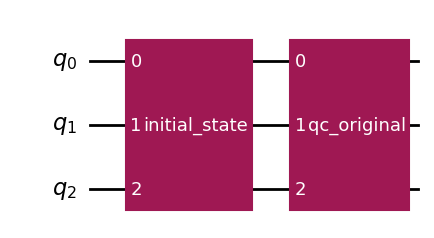

In [9]:
qc = QuantumCircuit(3)
qc.append(qc0_gate, [0,1,2])
qc.append(qc_gate, [0,1,2])
qc.draw("mpl")

In [10]:
state = Statevector(qc)
array_to_latex(state)

<IPython.core.display.Latex object>

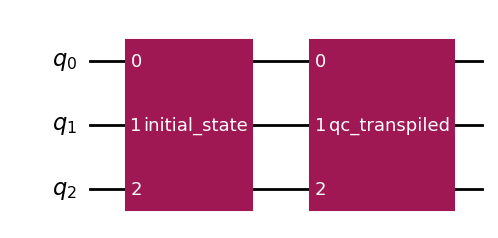

In [11]:
qc = QuantumCircuit(3)
qc.append(qc0_gate, [0,1,2])
qc.append(qc_transpiled_gate, [0,1,2])
qc.draw("mpl")

In [12]:
state = Statevector(qc)
array_to_latex(state)

<IPython.core.display.Latex object>

### (3) Execution on real quantum hardware (IBM)
- [qiskit-ibm-runtime](https://github.com/Qiskit/qiskit-ibm-runtime)

1. Access [ibm-cloud-quantum](https://quantum.cloud.ibm.com/)
2. create an account or log in
3. Create an API Key
4. Create an instance

<img src="../images/ibm_cloud_quantum.png" alt="Alt text" width="800" height="400">

4. Set the enviroment variables:
    - export QISKIT_IBM_TOKEN="MY_IBM_CLOUD_API_KEY"
    - export QISKIT_IBM_INSTANCE="MY_IBM_CLOUD_CRN"
    - export QISKIT_IBM_CHANNEL="ibm_cloud"

<img src="../images/ibm_cloud_quantum2.png" alt="Alt text" width="800" height="400">

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

In [25]:
backends = service.backends()
for backend in backends:
    print(f"Backend: {backend.name}, Qubits: {backend.configuration().n_qubits}, Status: {backend.status().operational}")

Backend: ibm_brisbane, Qubits: 127, Status: True
Backend: ibm_sherbrooke, Qubits: 127, Status: True
Backend: ibm_torino, Qubits: 133, Status: True


- [ibm_brisbane](https://quantum.cloud.ibm.com/?computer=ibm_brisbane)

<img src="../images/brisbance_architecture_error.png" alt="Alt text" width="400" height="400">

In [35]:
backend = service.least_busy()
#backend = service.backend("ibm_torino")

#### Execution
- [qiskit.transpiler.preset_passmanagers](https://docs.quantum.ibm.com/api/qiskit/transpiler_preset)

***Sampler***

In [40]:
# 1. A quantum circuit for preparing the quantum state (|00> + |11>)/rt{2}
bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
bell.measure_all()

# 2: Optimize problem for quantum execution.
backend = service.least_busy(operational=True, simulator=False)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(bell)

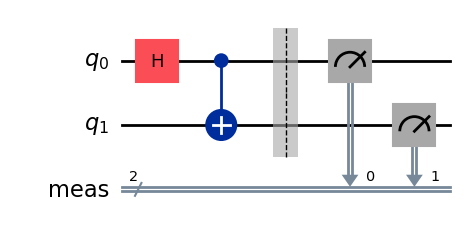

In [42]:
bell.draw("mpl")

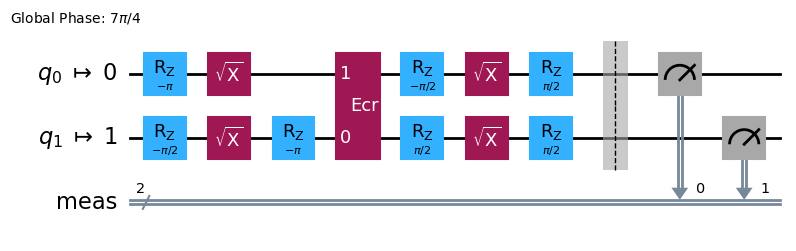

In [44]:
isa_circuit.draw("mpl")

In [45]:
sampler = Sampler(mode=backend)
sampler.options.default_shots = 1024
job = sampler.run([isa_circuit])
print(f"Job ID is {job.job_id()}")

Job ID is d0rkdg07m9ds739fbhcg


In [47]:
job.status()

'DONE'

In [48]:
pub_result = job.result()[0]
print(f"Counts for the meas output register: {pub_result.data.meas.get_counts()}")

Counts for the meas output register: {'11': 439, '00': 485, '10': 53, '01': 47}


***Estimator***

In [57]:
# 1. A quantum circuit for preparing the quantum state (|000> + e^{itheta} |111>)/rt{2}
theta = Parameter('θ')
circuit = QuantumCircuit(3)
circuit.h(0) # generate superposition
circuit.p(theta, 0) # add quantum phase
circuit.cx(0, 1) # condition 1st qubit on 0th qubit
circuit.cx(0, 2) # condition 2nd qubit on 0th qubit

In [60]:
# The observable to be measured
M1 = SparsePauliOp.from_list([("XXY", 1), ("XYX", 1), ("YXX", 1), ("YYY", -1)])
M1

SparsePauliOp(['XXY', 'XYX', 'YXX', 'YYY'],
              coeffs=[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j])

In [63]:
# batch of theta parameters to be executed
points = 50
theta1 = []
for x in range(points):
    theta = [x*2.0*np.pi/50]
    theta1.append(theta)

In [65]:
# 2: Optimize problem for quantum execution.
backend = service.least_busy()
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)
isa_observables = M1.apply_layout(isa_circuit.layout)

In [66]:
backend

<IBMBackend('ibm_torino')>

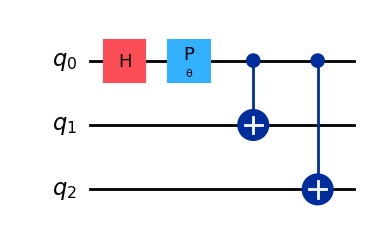

In [69]:
circuit.draw("mpl")

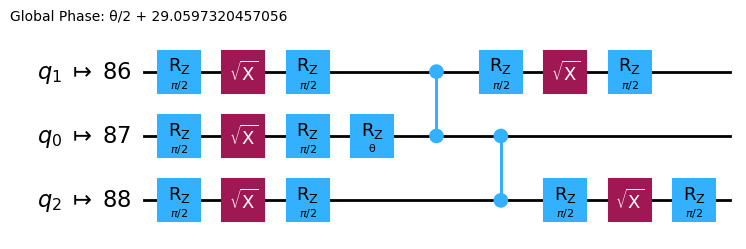

In [68]:
isa_circuit.draw("mpl")

In [93]:
M1

SparsePauliOp(['XXY', 'XYX', 'YXX', 'YYY'],
              coeffs=[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j])

In [70]:
isa_observables

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXYXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXYIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYXXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYYYIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j])

In [72]:
# 3. Execute using the Estimator primitive
estimator = Estimator(backend)
estimator.options.resilience_level = 1  # Options can be set using auto-complete.
job = estimator.run([(isa_circuit, isa_observables, theta1)])
print(f"Job ID is {job.job_id()}")

Job ID is d0rkmrvp51os73av57j0


In [74]:
job.status()

'RUNNING'

In [78]:
job.status()

'DONE'

In [83]:
job_result = job.result()

In [85]:
pub_result = job.result()[0]

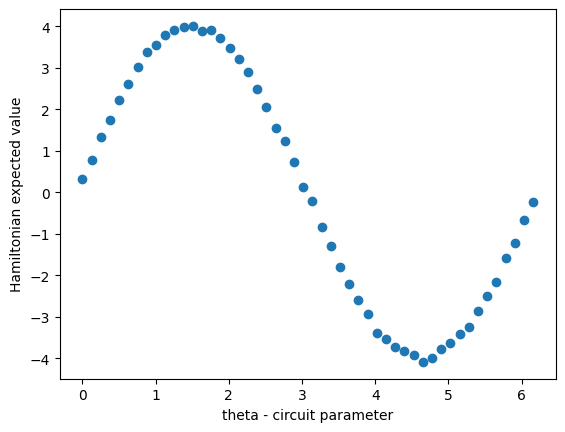

In [91]:
plt.scatter(theta1, pub_result.data.evs)
plt.xlabel('theta - circuit parameter')
plt.ylabel('Hamiltonian expected value')


plt.show()

"This code batches together 50 parameters to be executed in a single job. If a user wanted to find the theta that optimized the observable, they could plot and observe it occurs at ***theta=np.pi/2***. For speed we recommend batching results together (note that depending on your access, there may be limits on the number of circuits, objects, and parameters that you can send)." [Doc](https://github.com/Qiskit/qiskit-ibm-runtime)